# Gaussian Mixture Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from torch.nn import Softmax
from torch.autograd import Variable
import sys

import pyro
from pyro.infer.kl_qp import KL_QP
from pyro.distributions import categorical, delta, diagnormal, dirichlet, gamma, normal
from pyro.util import ng_zeros, ng_ones

In [3]:
softmax = Softmax()

def softmax_1d(x):
    assert x.dim() == 1
    return softmax(x.unsqueeze(0)).squeeze(0)

In [4]:
data = torch.Tensor([0, 1, 2, 7, 8, 9])

## Maximum likelihood approach

In [5]:
K = 2  # Fixed number of components.
z_values = np.array(range(K), dtype=np.int)

def model(data):
    # Global parameters.
    ps = softmax_1d(pyro.param('pre_ps', Variable(torch.zeros(K), requires_grad=True)))
    mu = pyro.param('mu', Variable(torch.normal(torch.zeros(K), torch.ones(K)), requires_grad=True))
    sigma = pyro.param('sigma', Variable(torch.ones(1), requires_grad=True))

    # Local parameters.
    for i, datum in enumerate(data):
        z = pyro.sample('z_{}'.format(i), categorical, ps, vs=z_values)[0]
        pyro.observe('x_{}'.format(i), diagnormal, datum, mu[z], sigma)

def guide(data):
    for i, datum in enumerate(data):
        p = softmax_1d(pyro.param('pre_p_{}'.format(i), Variable(torch.zeros(K), requires_grad=True)))
        pyro.sample('z_{}'.format(i), categorical, p, vs=z_values)            # SAMPLE

We'd like to implement EM by summing rather than sampling on the line marked "SAMPLE".

In [22]:
optim_fct = pyro.optim(torch.optim.Adam, {'lr': 1.0})
inference = KL_QP(model, guide, optim_fct, num_particles=10)

In [23]:
%pdb off
pyro.get_param_store().clear()  # See https://github.com/uber/pyro/issues/175
for _ in range(200):
    inference.step(data)
    sys.stdout.write('.')
    sys.stdout.flush()

Automatic pdb calling has been turned OFF
........................................................................................................................................................................................................

In [24]:
ps = softmax_1d(pyro.param('pre_ps'))
mu = pyro.param('mu')
sigma = pyro.param('sigma')
ps, mu, sigma

(Variable containing:
  0.5000
  0.5000
 [torch.FloatTensor of size 2], Variable containing:
  8.5001
  2.4998
 [torch.FloatTensor of size 2], Variable containing:
  2.2265
 [torch.FloatTensor of size 1])

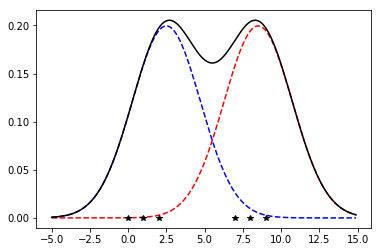

In [25]:
%matplotlib inline
import scipy.stats
from matplotlib import pyplot

X = np.arange(-5,15,0.1)
Y1 = ps.data[0] * scipy.stats.norm.pdf((X - mu.data[0]) / sigma.data[0])
Y2 = ps.data[1] * scipy.stats.norm.pdf((X - mu.data[1]) / sigma.data[0])
pyplot.plot(X, Y1, 'r--')
pyplot.plot(X, Y2, 'b--')
pyplot.plot(X, Y1 + Y2, 'k-')
pyplot.plot(data.numpy(), np.zeros(len(data)), 'k*')

## Fully Bayesian aproach

Let's start by modeling univariate real-valued data using a mixture of a fixed number of Gaussians with unknown weights `ps`, unknown means `mu`, and shared unknown variance `sigma`.

In [243]:
K = 2  # Fixed number of components.
z_values = np.array(range(K), dtype=np.int)
softmax = Softmax()
use_map_data = False

def model(data):
    # Global parameters.
    ps = pyro.sample('ps', dirichlet, alpha=ng_ones(K) * 0.5)

    # Per-component parameters with weak priors.
    mu = pyro.sample('mu', diagnormal, ng_zeros(K), ng_ones(K) * 100)
    sigma = pyro.sample('sigmasq', gamma, ng_ones(1) * 0.1, ng_ones(1) * 0.1) ** 0.5

    # Per-datum parameters.
    if use_map_data:
        def local_model(i, datum):
            z = pyro.sample('z_{}'.format(i), categorical, ps, vs=z_values)[0]
            pyro.observe('x_{}'.format(i), diagnormal, datum, mu[z], sigma)

        pyro.map_data('obs', data, local_model)
    else:
        for i, datum in enumerate(data):
            z = pyro.sample('z_{}'.format(i), categorical, ps, vs=z_values)[0]
            pyro.observe('x_{}'.format(i), diagnormal, datum, mu[z], sigma)

def guide(data):
    # Maximum-likelihood estimate latent parameters.
    ps_map = pyro.param('ps_map', torch.ones(K))
    mu_map = pyro.param('mu_map', torch.normal(torch.zeros(K), torch.ones(K)))
    sigma_map = pyro.param('sigma_map', torch.ones(1))

    ps = pyro.sample('ps', delta, ps_map)
    mu = pyro.sample('mu', delta, mu_map)
    sigma = pyro.sample('sigmasq', delta, sigma_map) ** 0.5

    if use_map_data:
        def local_guide(i, datum):
            p = pyro.param('p_{}'.format(i), torch.ones(K) / K)
            softmax_p = softmax(p.unsqueeze(0)).squeeze(0)  # Ugly.
            pyro.sample('z_{}'.format(i), categorical, softmax_p, vs=z_values)[0]

        pyro.map_data('obs', data, local_guide)
    else:
        for i, datum in enumerate(data):
            p = pyro.param('p_{}'.format(i), torch.ones(K) / K)
            softmax_p = softmax(p.unsqueeze(0)).squeeze(0)  # Ugly.
            pyro.sample('z_{}'.format(i), categorical, softmax_p, vs=z_values)[0]
        

In [244]:
optim_fct = pyro.optim(torch.optim.Adam, {'lr': 0.001})
inference = KL_QP(model, guide, optim_fct)

In [246]:
%pdb off
inference(data)

Automatic pdb calling has been turned OFF


RuntimeError: inconsistent tensor size, expected r_ [1], t [1] and src [2] to have the same number of elements, but got 1, 1 and 2 elements respectively at /Users/soumith/miniconda2/conda-bld/pytorch_1503975203422/work/torch/lib/TH/generic/THTensorMath.c:887